# Part 1: Data scraping and preparation

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
path = 'chromedriver_win32 (2)\chromedriver.exe'
from selenium.webdriver.chrome.options import Options
chrome_options = Options()
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Step 1: Scrape your competitor's data

In [2]:
driver = webdriver.Chrome(path)
driver.get("https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares") 

In [3]:
page = driver.page_source

In [4]:
soup = BeautifulSoup(page ,'html.parser')
clear_soup = soup.prettify()[:]
table = str(soup.find("table" ,attrs = {'class':"table"}))
top_50 = pd.DataFrame(data = pd.read_html(table)[0])
top_50.columns = ['rank','x_Class','date','region','start','maximum','end','movie']

In [5]:
top_50.head()

,rank,x_Class,date,region,start,maximum,end,movie
0,1,X28+,2003/11/04,486,19:29,19:53,20:06,MovieView archive
1,2,X20+,2001/04/02,9393,21:32,21:51,22:03,MovieView archive
2,3,X17.2+,2003/10/28,486,09:51,11:10,11:24,MovieView archive
3,4,X17+,2005/09/07,808,17:17,17:40,18:03,MovieView archive
4,5,X14.4,2001/04/15,9415,13:19,13:50,13:55,MovieView archive


### Step 2: Tidy the top 50 solar flare data

In [6]:
top_50.drop(['movie'] , axis = 1 , inplace = True)

In [7]:
top_50.head()

,rank,x_Class,date,region,start,maximum,end
0,1,X28+,2003/11/04,486,19:29,19:53,20:06
1,2,X20+,2001/04/02,9393,21:32,21:51,22:03
2,3,X17.2+,2003/10/28,486,09:51,11:10,11:24
3,4,X17+,2005/09/07,808,17:17,17:40,18:03
4,5,X14.4,2001/04/15,9415,13:19,13:50,13:55


In [8]:
top_50['start_time'] = pd.to_datetime(top_50['date'] + ' ' + top_50['start'])
top_50['max_time'] = pd.to_datetime(top_50['date'] + ' ' + top_50['maximum'])
top_50['end_time'] = pd.to_datetime(top_50['date'] + ' ' + top_50['end'])

In [9]:
top_50.drop(['date' , 'start' , 'maximum' , 'end'] , axis = 1 , inplace = True)

In [10]:
top_50 = top_50[['rank','x_Class','start_time','max_time','end_time' , 'region']]
top_50.head()

,rank,x_Class,start_time,max_time,end_time,region
0,1,X28+,2003-11-04 19:29:00,2003-11-04 19:53:00,2003-11-04 20:06:00,486
1,2,X20+,2001-04-02 21:32:00,2001-04-02 21:51:00,2001-04-02 22:03:00,9393
2,3,X17.2+,2003-10-28 09:51:00,2003-10-28 11:10:00,2003-10-28 11:24:00,486
3,4,X17+,2005-09-07 17:17:00,2005-09-07 17:40:00,2005-09-07 18:03:00,808
4,5,X14.4,2001-04-15 13:19:00,2001-04-15 13:50:00,2001-04-15 13:55:00,9415


### Step 3: Scrape the NASA data

In [11]:
req = requests.get('https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html') 

In [12]:
page = BeautifulSoup(req.content , 'html.parser')
table = page.find('pre')
table = table.text.split('\n')[9:-2]

In [13]:
col_names = ['Start_Date','Start_Time','End_Date','End_Time','Start_Frequancy','End_Frequancy','Flare_Location',
       'Flare_Region', 'Importance','CME_Date', 'CME_Time', 'CPA', 'Width', 'Speed', 'Plots']
raw_data = [i.split() for i in table]
Nasa = pd.DataFrame(data = raw_data)

In [14]:
Nasa.drop([i for i in range(15 , 24)] ,axis = 1 , inplace = True)
Nasa.drop([0 , 1 , 2] , axis = 0 , inplace = True)

In [17]:
Nasa.columns = col_names
Nasa.head()

,Start_Date,Start_Time,End_Date,End_Time,Start_Frequancy,End_Frequancy,Flare_Location,Flare_Region,Importance,CME_Date,CME_Time,CPA,Width,Speed,Plots
3,1997/04/01,14:00,04/01,14:15,8000,4000,S25E16,8026,M1.3,04/01,15:18,74,79,312,PHTX
4,1997/04/07,14:30,04/07,17:30,11000,1000,S28E19,8027,C6.8,04/07,14:27,Halo,360,878,PHTX
5,1997/05/12,05:15,05/14,16:00,12000,80,N21W08,8038,C1.3,05/12,05:30,Halo,360,464,PHTX
6,1997/05/21,20:20,05/21,22:00,5000,500,N05W12,8040,M1.3,05/21,21:00,263,165,296,PHTX
7,1997/09/23,21:53,09/23,22:16,6000,2000,S29E25,8088,C1.4,09/23,22:02,133,155,712,PHTX


### Step 4: Tidy the NASA table

2. The CPA column (cme_angle) contains angles in degrees for most rows, except for halo
flares, which are coded as “Halo”. Create a new column that indicates if a row
corresponds to a halo flare or not, and then replace Halo entries in the cme_angle
column as NA.

In [18]:
Nasa['Is_Halo'] = Nasa['CPA'].apply(lambda x : True if x == 'Halo' else False)

In [19]:
Nasa['CPA'] = Nasa['CPA'].apply(lambda x : np.nan if x == 'Halo' else x  ) 

In [20]:
Nasa.head()

,Start_Date,Start_Time,End_Date,End_Time,Start_Frequancy,End_Frequancy,Flare_Location,Flare_Region,Importance,CME_Date,CME_Time,CPA,Width,Speed,Plots,Is_Halo
3,1997/04/01,14:00,04/01,14:15,8000,4000,S25E16,8026,M1.3,04/01,15:18,74,79,312,PHTX,False
4,1997/04/07,14:30,04/07,17:30,11000,1000,S28E19,8027,C6.8,04/07,14:27,NaN,360,878,PHTX,True
5,1997/05/12,05:15,05/14,16:00,12000,80,N21W08,8038,C1.3,05/12,05:30,NaN,360,464,PHTX,True
6,1997/05/21,20:20,05/21,22:00,5000,500,N05W12,8040,M1.3,05/21,21:00,263,165,296,PHTX,False
7,1997/09/23,21:53,09/23,22:16,6000,2000,S29E25,8088,C1.4,09/23,22:02,133,155,712,PHTX,False


3. The width column indicates if the given value is a lower bound. Create a new column that
indicates if width is given as a lower-bound, and remove any non-numeric part of the
width column.

In [21]:
Nasa['Is_lower'] = Nasa['Width'].apply(lambda x : True if x[0] == '>' else False )

In [22]:
Nasa['Width'] = Nasa['Width'].apply(lambda x : x[1:] if x[0] == '>' else x )

4. Combine date and time columns for start, end and cme so they can be encoded as
datetime objects.

In [23]:
Nasa['CME_Time'] = Nasa['CME_Time'].apply(lambda x : '00:00' if x == '--:--' else x )

In [24]:
Nasa['CME_Date'] = Nasa['CME_Date'].apply(lambda x : '01/01' if x == '--/--' else x )

In [25]:
Nasa['Year'] = Nasa['Start_Date'].apply(lambda x : x.split('/')[0])

In [26]:
Nasa['CME_Date'] += '/' + Nasa['Year']

In [27]:
Nasa['CME_DateTime'] = pd.to_datetime(Nasa['CME_Date'] + ' ' + Nasa['CME_Time'])

In [28]:
Nasa['Start_DateTime'] = pd.to_datetime(Nasa['Start_Date'] + ' ' + Nasa['Start_Time'])

In [29]:
Nasa['End_Date'] += '/' + Nasa['Year']

In [30]:
Nasa['End_Time'] = Nasa['End_Time'].apply(lambda x : '00' + x[2:] if int(x.split(':')[0]) == 24 else x )

In [31]:
Nasa['End_DateTime'] = pd.to_datetime(Nasa['End_Date'] + ' ' + Nasa['End_Time'])

In [32]:
Nasa.drop(['Start_Date','Start_Time','End_Date','End_Time','CME_Date','CME_Time'] , axis = 1 , inplace = True)

In [33]:
Nasa.head()

,Start_Frequancy,End_Frequancy,Flare_Location,Flare_Region,Importance,CPA,Width,Speed,Plots,Is_Halo,Is_lower,Year,CME_DateTime,Start_DateTime,End_DateTime
3,8000,4000,S25E16,8026,M1.3,74,79,312,PHTX,False,False,1997,1997-04-01 15:18:00,1997-04-01 14:00:00,1997-04-01 14:15:00
4,11000,1000,S28E19,8027,C6.8,NaN,360,878,PHTX,True,False,1997,1997-04-07 14:27:00,1997-04-07 14:30:00,1997-04-07 17:30:00
5,12000,80,N21W08,8038,C1.3,NaN,360,464,PHTX,True,False,1997,1997-05-12 05:30:00,1997-05-12 05:15:00,1997-05-14 16:00:00
6,5000,500,N05W12,8040,M1.3,263,165,296,PHTX,False,False,1997,1997-05-21 21:00:00,1997-05-21 20:20:00,1997-05-21 22:00:00
7,6000,2000,S29E25,8088,C1.4,133,155,712,PHTX,False,False,1997,1997-09-23 22:02:00,1997-09-23 21:53:00,1997-09-23 22:16:00


In [34]:
Nasa.drop(['Year'] , axis = 1 , inplace = True)
col = ['CME_DateTime','Start_DateTime','End_DateTime','Start_Frequancy','End_Frequancy','Flare_Location','Flare_Region','Importance',
       'CPA','Width','Speed','Plots','Is_Halo','Is_lower']
Nasa = Nasa[col]
Nasa.head()

,CME_DateTime,Start_DateTime,End_DateTime,Start_Frequancy,End_Frequancy,Flare_Location,Flare_Region,Importance,CPA,Width,Speed,Plots,Is_Halo,Is_lower
3,1997-04-01 15:18:00,1997-04-01 14:00:00,1997-04-01 14:15:00,8000,4000,S25E16,8026,M1.3,74,79,312,PHTX,False,False
4,1997-04-07 14:27:00,1997-04-07 14:30:00,1997-04-07 17:30:00,11000,1000,S28E19,8027,C6.8,NaN,360,878,PHTX,True,False
5,1997-05-12 05:30:00,1997-05-12 05:15:00,1997-05-14 16:00:00,12000,80,N21W08,8038,C1.3,NaN,360,464,PHTX,True,False
6,1997-05-21 21:00:00,1997-05-21 20:20:00,1997-05-21 22:00:00,5000,500,N05W12,8040,M1.3,263,165,296,PHTX,False,False
7,1997-09-23 22:02:00,1997-09-23 21:53:00,1997-09-23 22:16:00,6000,2000,S29E25,8088,C1.4,133,155,712,PHTX,False,False


# Part 2: Analysis

### Question 1: Replication
Can you replicate the top 50 solar flare table in SpaceWeatherLive.com exactly using the
data obtained from NASA? That is, if you get the top 50 solar flares from the NASA table
based on their classification (e.g., X28 is the highest), do you get data for the same solar
flare events?

In [35]:
x_top50 = Nasa[ Nasa['Importance'].str.contains('X')]
x_top50['Importance_Rank'] = x_top50['Importance'].apply(lambda x : float(x[1:]))

In [36]:
x_top50.sort_values(ascending = False , by = 'Importance_Rank' , inplace = True)
x_top50.head(50)

,CME_DateTime,Start_DateTime,End_DateTime,Start_Frequancy,End_Frequancy,Flare_Location,Flare_Region,Importance,CPA,Width,Speed,Plots,Is_Halo,Is_lower,Importance_Rank
243,2003-11-04 19:54:00,2003-11-04 20:00:00,2003-11-04 00:00:00,10000,200,S19W83,10486,X28.,NaN,360,2657,PHTX,True,False,28.0
120,2001-04-02 22:06:00,2001-04-02 22:05:00,2001-04-03 02:30:00,14000,250,N19W72,9393,X20.,261,244,2505,PHTX,False,False,20.0
236,2003-10-28 11:30:00,2003-10-28 11:10:00,2003-10-29 00:00:00,14000,40,S16E08,10486,X17.,NaN,360,2459,PHTX,True,False,17.0
129,2001-04-15 14:06:00,2001-04-15 14:05:00,2001-04-16 13:00:00,14000,40,S20W85,9415,X14.,245,167,1199,PHTX,False,False,14.0
237,2003-10-29 20:54:00,2003-10-29 20:55:00,2003-10-29 00:00:00,11000,500,S15W02,10486,X10.,NaN,360,2029,PHTX,True,False,10.0
11,1997-11-06 12:10:00,1997-11-06 12:20:00,1997-11-07 08:30:00,14000,100,S18W63,8100,X9.4,NaN,360,1556,PHTX,True,False,9.4
517,2017-09-06 12:24:00,2017-09-06 12:05:00,2017-09-07 08:00:00,16000,70,S08W33,12673,X9.3,NaN,360,1571,PHTX,True,False,9.3
331,2006-01-01 00:00:00,2006-12-05 10:50:00,2006-12-05 20:00:00,14000,250,S07E68,10930,X9.0,----,----,----,PHTX,False,False,9.0
240,2003-11-02 17:30:00,2003-11-02 17:30:00,2003-11-03 01:00:00,12000,250,S14W56,10486,X8.3,NaN,360,2598,PHTX,True,False,8.3
518,2017-09-10 16:00:00,2017-09-10 16:02:00,2017-09-11 06:50:00,16000,150,S09W92,-----,X8.3,NaN,360,3163,PHTX,True,False,8.3


### Question 2: Integration
Write a function that finds the best matching row in the NASA data for each of the top
50 solar flares in the SpaceWeatherLive data. Here, you have to decide for yourself how
you determine what is the best matching entry in the NASA data for each of the top 50
solar flares.

In [46]:
top_50['region'].dtype

dtype('int64')

In [62]:
def convert_int(n):
    try :
        return int(n)
    except :
        return np.nan

In [64]:
Nasa['Flare_Region'] = Nasa['Flare_Region'].apply(convert_int)

In [66]:
best_mathces = pd.merge(left = Nasa , right = top_50 , how = 'inner' , left_on = 'Flare_Region' ,
        right_on = 'region')

In [67]:
best_mathces.head()

,CME_DateTime,Start_DateTime,End_DateTime,Start_Frequancy,End_Frequancy,Flare_Location,Flare_Region,Importance,CPA,Width,Speed,Plots,Is_Halo,Is_lower,rank,x_Class,start_time,max_time,end_time,region
0,1997-11-03 05:28:00,1997-11-03 05:15:00,1997-11-03 12:00:00,14000,250,S20W13,8100.0,C8.6,240,109,227,PHTX,False,False,7,X9.4,1997-11-06 11:49:00,1997-11-06 11:55:00,1997-11-06 12:01:00,8100
1,1997-11-03 11:11:00,1997-11-03 10:30:00,1997-11-03 11:30:00,14000,5000,S16W21,8100.0,M4.2,233,122,352,PHTX,False,False,7,X9.4,1997-11-06 11:49:00,1997-11-06 11:55:00,1997-11-06 12:01:00,8100
2,1997-11-04 06:10:00,1997-11-04 06:00:00,1997-11-05 04:30:00,14000,100,S14W33,8100.0,X2.1,NaN,360,785,PHTX,True,False,7,X9.4,1997-11-06 11:49:00,1997-11-06 11:55:00,1997-11-06 12:01:00,8100
3,1997-11-06 12:10:00,1997-11-06 12:20:00,1997-11-07 08:30:00,14000,100,S18W63,8100.0,X9.4,NaN,360,1556,PHTX,True,False,7,X9.4,1997-11-06 11:49:00,1997-11-06 11:55:00,1997-11-06 12:01:00,8100
4,1998-04-23 05:55:00,1998-04-23 06:00:00,1998-04-23 15:30:00,14000,200,S17E90,8210.0,X1.2,NaN,360,1691,PHTX,True,False,48,X2.7,1998-05-06 07:58:00,1998-05-06 08:09:00,1998-05-06 08:20:00,8210


### Question 3: Analysis

<AxesSubplot:xlabel='Width', ylabel='Start_Frequancy'>

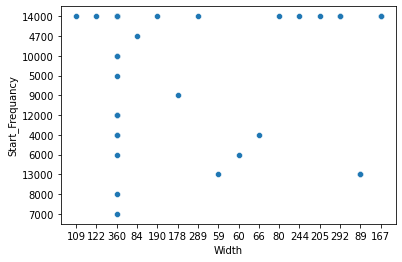

In [76]:
sns.scatterplot(data = best_mathces ,  x = 'Width' , y = 'Start_Frequancy')

In [77]:
best_mathces['Month'] = best_mathces['Start_DateTime'].dt.month

<AxesSubplot:xlabel='Month', ylabel='count'>

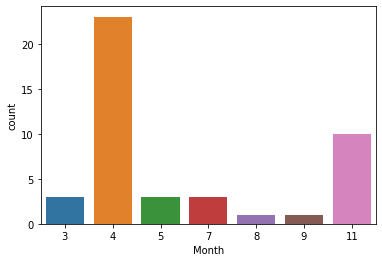

In [78]:
sns.countplot(data = best_mathces , x = 'Month')